In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' &> /dev/null

In [ ]:
from PIL import Image as I
from PIL import ImageFilter
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix as cm
from distutils.file_util import copy_file
import random
np.set_printoptions(suppress=True)

In [ ]:
non = '/content/Data/Non Demented'
vmild = '/content/Data/Very mild Dementia'
mild = '/content/Data/Mild Dementia'
mod = '/content/Data/Moderate Dementia'

In [ ]:
listmod = []
listnon = []
listvmild = []
listmild = []

for root, directories, files in os.walk(mod):
    for name in files:
        listmod.append(os.path.join(root, name))
for root, directories, files in os.walk(non):
    for name in files:
        listnon.append(os.path.join(root, name))
for root, directories, files in os.walk(vmild):
    for name in files:
        listvmild.append(os.path.join(root, name))
for root, directories, files in os.walk(mild):
    for name in files:
        listmild.append(os.path.join(root, name))

seed_value = 0
random.seed(seed_value)
random.shuffle(listmod)
random.shuffle(listnon)
random.shuffle(listvmild)
random.shuffle(listmild)

!mkdir ./Newdata
!mkdir ./Newdata/alz
!mkdir ./Newdata/notalz

In [ ]:
alz = '/content/Newdata/alz'
notalz = '/content/Newdata/notalz'
n=488
m=162
for i in range(n):
    copy_file(listnon[i], notalz)
for i in range(m):
    copy_file(listvmild[i], alz)
    copy_file(listmild[i], alz)
    copy_file(listmod[i], alz)

In [ ]:
# alz = '/content/Newdata/alz'
# notalz = '/content/Newdata/notalz'
# n=488
# for i in range(n):
#     copy_file(listmod[i], notalz)
# for i in range(n):
#     copy_file(listvmild[i], alz)

In [ ]:
dir = [alz,notalz]
main_image_list = []
labels = []

for i in range(2):
    location = sorted( os.listdir( dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( dir[i] , file_name )
        image = I.open(file_path)
        new_image = image.convert('L').resize((128,64))
        image2D = np.array(new_image)
        image1D = image2D.flatten()
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list)
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    main_image_list.append(concatenated_images)
    labels.append(concatenated_labels)

(486, 8192)
(488, 8192)


In [ ]:
main_image_list = np.vstack(main_image_list)

In [ ]:
labels = np.vstack(labels)

In [ ]:
data = np.concatenate((labels, main_image_list), axis=1)
df = pd.DataFrame(data)

In [ ]:
random_seed = 0
S_df = df.sample(frac=1, random_state = random_seed)

In [ ]:
train_df, test_df = split(S_df, test_size= 1/3, random_state=0)

In [ ]:
n_df = train_df.iloc[:,:1]

In [ ]:
p_df = train_df.iloc[:,1:]

In [ ]:
n_df_t = test_df.iloc[:,:1]

In [ ]:
p_df_t = test_df.iloc[:,1:]

### PCA

In [ ]:
mean = np.mean(p_df, axis=0)
p_df = p_df- mean
p_df_t = p_df_t -mean
covar = np.cov(p_df,rowvar=False)

In [ ]:
e1,e2 = np.linalg.eig(covar)

In [ ]:
e2= e2[:,np.argsort(e1)[::-1]]
e_proj = e2[:,:1500]

In [ ]:
p_df = np.dot(p_df,e_proj)

In [ ]:
p_df_t = np.dot(p_df_t,e_proj)

### Training

In [ ]:
X_train = p_df
Y_train = n_df
X_test = p_df_t
Y_test = n_df_t

In [ ]:
Y_train = Y_train.values.flatten()
Y_test = Y_test.values.flatten()

In [ ]:
X_train_0 = X_train[Y_train == 0]
X_train_1 = X_train[Y_train == 1]

### Mean and Covariance

In [ ]:
mean_0 = np.mean(X_train_0,axis=0)
mean_1 = np.mean(X_train_1,axis=0)
cov_0 = np.cov(X_train_0,rowvar=False)
cov_1 = np.cov(X_train_1,rowvar=False)

### Sw & Sb

In [ ]:
Sw = cov_0 + cov_1
Sb = np.outer((mean_0 - mean_1).T, (mean_0 - mean_1))

### Projections

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.pinv(Sw) , Sb))
nz_eig = np.argmax(eigenvalues)
proj = eigenvectors[:, nz_eig]

In [ ]:
Pred_t = np.dot(X_train,proj)
Pred = np.dot(X_test,proj)

### Calculation for Validation

In [ ]:
y_pred = Pred
y_pred_train = Pred_t

In [ ]:
t1 = np.mean(Pred_t[Y_train == 0])
t2 = np.mean(Pred_t[Y_train == 1])

for i in range(len(Pred)):
    d1 = abs(Pred[i] - t1)
    d2 = abs(Pred[i] - t2)
    if d1 < d2:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [ ]:
np.mean(y_pred == Y_test)

0.7784615384615384

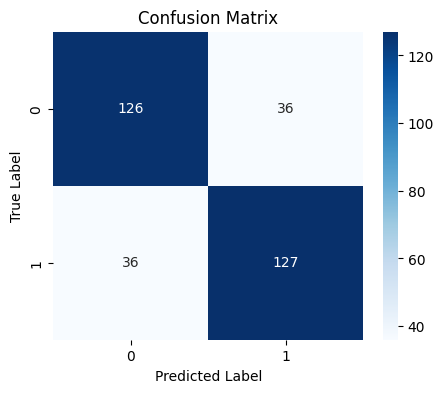

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, np.real(y_pred))

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()